In [29]:
import random
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed

class card_tag:
    def __init__(self, cost = None, land = False, fetch = False, cycle = False, cycle_cost = None, surveil = False, fetch_cost = None, land_type = None, can_fetch = None, protection = False, untapped = True, sac_target = False, sac_outlet = False, produces_green = False, produces_blue = False, green = False, pitch_cost = None, cantrip = False, cantrip_power = None,):
        self.cost = cost
        self.land = land
        self.fetch = fetch
        self.surveil = surveil
        self.fetch_cost = fetch_cost
        self.land_type = land_type
        self.can_fetch = can_fetch
        self.untapped = untapped
        self.protection = protection
        self.sac_target = sac_target
        self.sac_outlet = sac_outlet
        self.produces_green = produces_green
        self.produces_blue = produces_blue
        self.green = green
        self.pitch_cost = pitch_cost
        self.cycle = cycle
        self.cycle_cost = cycle_cost
        self.cantrip = cantrip
        self.cantrip_power = cantrip_power

CARD_TAGS = {
    "Allosaurus Rider" : card_tag(sac_target=True, green=True, pitch_cost="GG"),
    "Atraxa, Grand Unifier" : card_tag(green=True),
    "Boseiju, Who Endures" : card_tag(land=True, produces_green=True),
    "Breeding Pool" : card_tag(land=True, produces_green=True, produces_blue=True, land_type=["Forest", "Island"]),
    "Bridgeworks Battle" : card_tag(land=True, green=True, produces_green=True),
    "Consign to Memory" : card_tag(),
    "Disciple of Freyalise" : card_tag(land=True, green=True, produces_green=True),
    "Eldritch Evolution": card_tag(cost = "GGC", sac_outlet=True, green=True,),
    "Endurance": card_tag(green=True),
    "Flooded Strand": card_tag(land=True, fetch=True, can_fetch=['Island', 'Plain']),
    "Forest": card_tag(land=True, land_type=["Forest"], produces_green=True),
    "Generous Ent": card_tag(green=True, cycle=True, can_fetch=["Forest"], cycle_cost=1),
    "Ghalta, Stampede Tyrant": card_tag(green=True,),
    "Griselbrand": card_tag(),
    "Hedge Maze": card_tag(land=True, untapped=False, produces_green=True, produces_blue=True, land_type=['Island', "Forest"], surveil=True,),
    "Hooting Mandrills": card_tag(green=True), # for now I'll ignore mandrills, I'll implement delve later
    "Island" : card_tag(land=True, land_type=['Island'], produces_green=True),
    "Misty Rainforest": card_tag(land=True, fetch=True, can_fetch=['Island', 'Forest']),
    "Neoform": card_tag(cost = "UG", sac_outlet=True, green=True,),
    "Pact of Negation" : card_tag(protection=True),
    "Planar Genesis": card_tag(cost = "UG", green=True, cantrip=True, cantrip_power=4),
    "Preordain": card_tag(cost = "U", cantrip=True, cantrip_power=3),
    "Scalding Tarn": card_tag(land=True, fetch=True, can_fetch=['Island', 'Mountain']),
    "Summoner's Pact": card_tag(sac_target=True, green=True, pitch_cost="GG"), # for now we'll just consider pact as additional copies of Rider
    "Veil of Summer": card_tag(cost = "G", green=True, protection=True),
    "Xenagos, God of Revels": card_tag(green=True)
}

In [30]:
def get_starting_hand(deck):
    return deck[:7]

def initialize_deck(deck_list):
    deck = []

    for key, value in deck_list.items():
        deck.extend([key]*value)

    random.shuffle(deck)
    deck_card_tags = [CARD_TAGS[card] for card in deck]

    full_deck = [(name, tags) for name, tags in zip(deck, deck_card_tags)]

    return full_deck

def draw(deck, n):
    drawn_cards = []
    for i in range(n):
        drawn_cards.append(deck.pop(0))

    return drawn_cards

def get_card_names(card_list):
    return [card[0] for card in card_list]

def get_missing_mana(card, mana_pool = []):
    temp_mana_pool = mana_pool.copy()
    cost = card[1].cost
    missing_mana = []
    for pip in cost:
        if pip != "C":
            # for colored mana, check if we have a land that only produces that mana and tap it, if not, tap a dual
            candidates = [i for i, src in enumerate(temp_mana_pool) if src == [pip]]
            if len(candidates) > 0:
                temp_mana_pool.pop(candidates[0])
            else:
                candidates = [i for i, src in enumerate(temp_mana_pool) if pip in src]
                if len(candidates) > 0:
                    temp_mana_pool.pop(candidates[0])
                else:
                    missing_mana.append(pip)
        else:
            # for generic mana, tap the land of the color we have the most of, if equal, tap green (?)
            candidates = [i for i, src in enumerate(temp_mana_pool) if len(src) == 1]
            if len(candidates) > 0:
                green_singles = np.sum(np.array(candidates) == ['G'])
                blue_singles = np.sum(np.array(candidates) == ['U'])

                if green_singles >= blue_singles:
                    candidates = [i for i, src in enumerate(temp_mana_pool) if src == ['G']]
                    temp_mana_pool.pop(candidates[0])
                else:
                    candidates = [i for i, src in enumerate(temp_mana_pool) if src == ['U']]
                    temp_mana_pool.pop(candidates[0])
            else:
                candidates = [i for i, src in enumerate(temp_mana_pool) if len(src) > 0] # we cannot tap fetch lands for mana
                if len(candidates) > 0:
                    temp_mana_pool.pop(candidates[0])
                else:
                    missing_mana.append(pip)

    return missing_mana

def pay_mana_cost(cost, mana_pool):
    temp_mana_pool = mana_pool.copy()
    for pip in cost:
        if pip != "C":
            candidates = [i for i, src in enumerate(temp_mana_pool) if src == [pip]]
            if len(candidates) > 0:
                temp_mana_pool.pop(candidates[0])
            else:
                candidates = [i for i, src in enumerate(temp_mana_pool) if pip in src]
                if len(candidates) > 0:
                    temp_mana_pool.pop(candidates[0])
        else:
            # for generic mana, tap the land of the color we have the most of, if equal, tap green (?)
            candidates = [i for i, src in enumerate(temp_mana_pool) if len(src) == 1]
            if len(candidates) > 0:
                green_singles = np.sum(np.array(candidates) == ['G'])
                blue_singles = np.sum(np.array(candidates) == ['U'])

                if green_singles >= blue_singles:
                    candidates = [i for i, src in enumerate(temp_mana_pool) if src == ['G']]
                    temp_mana_pool.pop(candidates[0])
                else:
                    candidates = [i for i, src in enumerate(temp_mana_pool) if src == ['U']]
                    temp_mana_pool.pop(candidates[0])
            else:
                candidates = [i for i, src in enumerate(temp_mana_pool) if len(src) > 0] # we cannot tap fetch lands for mana
                if len(candidates) > 0:
                    temp_mana_pool.pop(candidates[0])
    return temp_mana_pool

def get_mana_production_of_land(land):
    tags = land[1]
    if tags.land_type:
        return len(tags.land_type)
    else:
        return 1 

def fetch(fetch_land, deck, missing_combo_pieces, missing_mana):
    # same kind of logic as for playing lands, except this time we can't fetch :p
    missing_mana_count = [len(missing_mana) for missing_mana in missing_mana]
    missing_mana = sorted(missing_mana, key=lambda x: len(x))

    fetchable_types = fetch_land[1].can_fetch
    lands_with_types = [card for card in deck if card[1].land_type]
    fetchable_lands = [card for card in lands_with_types if np.any([land_type in fetchable_types for land_type in card[1].land_type])]

    untapped_lands = [land for land in fetchable_lands if land[1].untapped]
    untapped_duals = [land for land in untapped_lands if (land[1].produces_green and land[1].produces_blue)]
    untapped_green_source = [land for land in untapped_lands if land[1].produces_green]
    untapped_blue_source = [land for land in untapped_lands if land[1].produces_blue]
    surveil_lands = [land for land in fetchable_lands if land[1].surveil]

    if len(missing_mana_count) > 0 and np.min(missing_mana_count) == 1:
        # priority, play land that makes the mana you want from your hand, if you can't, fetch for it (always prefer duals)
        pip = missing_mana[0]
        if untapped_duals:
            return untapped_duals[0]
        elif pip == "G":
            if untapped_green_source:
                return untapped_green_source[0]
            else:
                pass
        elif pip == "U":
            if untapped_blue_source:
                return untapped_blue_source[0]
            else:
                pass
        else:
            # generic mana, in this case, priority : blue -> green -> fetch
            if untapped_blue_source:
                return untapped_blue_source[0]
            elif untapped_green_source:
                return untapped_green_source[0]
            else:
                pass

    if surveil_lands:
        return surveil_lands[0]
    else:
        if untapped_duals:
            return untapped_duals[0]
        if untapped_blue_source:
            return untapped_blue_source[0]
        elif untapped_green_source:
            return untapped_green_source[0]

def surveil(deck, missing_sac_target, missing_sac_outlet, missing_mana, lands_in_hand, missing_green_cards, missing_cantrip):
    card_on_top = deck[0]
    if len(missing_mana)>0:
        missing_mana_count = np.min([len(missing_mana) for missing_mana in missing_mana])
    else:
        missing_mana_count = 0
    if missing_sac_outlet and card_on_top[1].sac_outlet:
        pass
    elif missing_sac_target and card_on_top[1].sac_target:
            pass
    elif missing_mana_count > len(lands_in_hand) and card_on_top[1].land:
        pass
    elif missing_green_cards and card_on_top[1].green:
        pass
    elif missing_cantrip and card_on_top[1].cantrip:
        pass
    else:
        deck.pop(0)

def check_if_castable(card, mana_pool=[]):
    missing_mana = get_missing_mana(card, mana_pool)
    return len(missing_mana) == 0

def check_for_win(hand, mana_pool, deck):
    sac_targets = [card for card in hand if card[1].sac_target]
    sac_outlets = [card for card in hand if card[1].sac_outlet]

    green_cards = [card for card in hand if card[1].green]
    sac_outlet_castable = np.any([check_if_castable(sac_outlet, mana_pool) for sac_outlet in sac_outlets])
    sac_target_castable = (len(sac_targets) >= 0) & (len(green_cards) >= 4) # you need to take the rider and the sac outlet into account
    win = sac_outlet_castable & sac_target_castable

    missing_mana_to_cast_sac_outlet = [get_missing_mana(sac_outlet, mana_pool) for sac_outlet in sac_outlets]

    # in case we don't have a sac outlet in hand, we still sometimes need to check if we potentially could case neoform / EE
    if not missing_mana_to_cast_sac_outlet:
        sac_outlets_in_deck = [card for card in deck if card[1].sac_outlet]
        sac_outlets_in_deck = list(set(sac_outlets_in_deck))
        missing_mana_to_cast_sac_outlet = [get_missing_mana(sac_outlet, mana_pool) for sac_outlet in sac_outlets_in_deck]

    missing_sac_target = (len(sac_targets) == 0)
    missing_sac_outlet = (len(sac_outlets) == 0)
    missing_green_cards = len(green_cards) < 4

    if not win:
        return False, (missing_mana_to_cast_sac_outlet, missing_sac_target, missing_sac_outlet, missing_green_cards)
    else:
        return True, ([], False, False, False)
    
def check_for_cantrip(hand, mana_pool):
    cantrips = [card for card in hand if card[1].cantrip]
    # sort them by cantrip power
    cantrips = sorted(cantrips, key=lambda c: getattr(c[1], "cantrip_power", 0), reverse=True)
    missing_cantrip = len(cantrips) == 0
    castable_cantrips = [card for card in cantrips if check_if_castable(card, mana_pool)]
    missing_mana_to_cast_cantrip = [get_missing_mana(cantrip, mana_pool) for cantrip in cantrips]

    return castable_cantrips, missing_cantrip, missing_mana_to_cast_cantrip
    
def play_land(lands_in_hand, missing_mana):
    # two branches, either we're trying to cast something (we need the mana NOW) or it's more long term (we probably want to fetch / play a surveil land)
    missing_mana_count = [len(missing_mana) for missing_mana in missing_mana]
    missing_mana = sorted(missing_mana, key=lambda x: len(x))
    untapped_lands_in_hand = [land for land in lands_in_hand if land[1].untapped]
    fetch_lands_in_hand = [land for land in lands_in_hand if land[1].fetch]
    untapped_duals = [land for land in untapped_lands_in_hand if (land[1].produces_green and land[1].produces_blue)]
    untapped_green_source = [land for land in untapped_lands_in_hand if land[1].produces_green]
    untapped_blue_source = [land for land in untapped_lands_in_hand if land[1].produces_blue]
    surveil_lands_in_hand = [land for land in lands_in_hand if land[1].surveil]

    if len(missing_mana_count) > 0 and np.min(missing_mana_count) == 1:
        # priority, play land that makes the mana you want from your hand, if you can't, fetch for it (always prefer duals)
        pip = missing_mana[0]
        
        if untapped_duals:
            return untapped_duals[0]
        elif pip == "G":
            if untapped_green_source:
                return untapped_green_source[0]
            elif fetch_lands_in_hand:
                return fetch_lands_in_hand[0]
            else:
                pass
        elif pip == "U":
            if untapped_blue_source:
                return untapped_blue_source[0]
            elif fetch_lands_in_hand:
                return fetch_lands_in_hand[0]
            else:
                pass
        else:
            # generic mana, in this case, priority : blue -> green -> fetch
            if untapped_blue_source:
                return untapped_blue_source[0]
            elif untapped_green_source:
                return untapped_green_source[0]
            elif fetch_lands_in_hand:
                return fetch_lands_in_hand[0]
            else:
                pass
            
    # if we're here, it's because we either didn't manage to play a land that let's us play something, or because we don't care about doing it this turn
    
    if surveil_lands_in_hand:
        return surveil_lands_in_hand[0]
    elif fetch_lands_in_hand:
        return fetch_lands_in_hand[0]
    else:
        if untapped_green_source:
            return untapped_green_source[0]
        if untapped_blue_source:
            return untapped_blue_source[0]

def process_played_land(land, hand, battlefield, mana_pool, mana_pool_for_turn, lands_in_hand, deck, missing_sac_target, missing_sac_outlet, missing_green_cards, missing_mana, missing_cantrip):
    missing_combo_pieces = missing_green_cards or missing_sac_outlet or missing_sac_target

    hand.remove(land)
    if land[1].fetch:
        fetched_land = fetch(land, deck, missing_combo_pieces, missing_mana)
        if fetched_land is not None:
            deck.remove(fetched_land)
            random.shuffle(deck)
            battlefield.append(fetched_land)
        else:
            battlefield.append(land)
    else:
        battlefield.append(land)

    if getattr(battlefield[-1][1], "surveil", False):
        surveil(deck, missing_sac_target, missing_sac_outlet, missing_mana, lands_in_hand, missing_green_cards, missing_cantrip)

    land_production = []
    if getattr(battlefield[-1][1], "produces_green", False):
        land_production.append('G')
    if getattr(battlefield[-1][1], "produces_blue", False):
        land_production.append('U')
    if getattr(battlefield[-1][1], "untapped", False):
        mana_pool_for_turn.append(land_production)
    mana_pool.append(land_production)

def cantrip(card, mana_pool, hand, deck, missing_sac_target, missing_sac_outlet, missing_mana, lands_in_hand, missing_green_cards):
    cantrip_cost = card[1].cost
    # pay the mana
    mana_pool = pay_mana_cost(cantrip_cost, mana_pool)
    hand.remove(card)
    
    cantrip_pool = []
    
    for i in range(card[1].cantrip_power):
        cantrip_pool.append(deck.pop(0))

    sac_targets = [card for card in cantrip_pool if card[1].sac_target]
    sac_outlets = [card for card in cantrip_pool if card[1].sac_outlet]
    lands = [card for card in cantrip_pool if card[1].land]
    green_cards = [card for card in cantrip_pool if card[1].green]
    cantrips = [card for card in cantrip_pool if card[1].cantrip]

    # sort sac outlets by increasing mana cost (fewest pips first)
    sac_outlets = sorted(sac_outlets, key=lambda c: len(getattr(c[1], "cost", [])))

    # sort cantrips by descending cantrip_power (highest power first)
    cantrips = sorted(cantrips, key=lambda c: getattr(c[1], "cantrip_power", 0), reverse=True)
    # choose a card from the cantrip pool based on missing pieces / priorities
    card = None
    if missing_sac_target and len(sac_targets) > 0:
        card = sac_targets[0]
    elif missing_sac_outlet and len(sac_outlets) > 0:
        card = sac_outlets[0]
    elif missing_mana and len(lands) > 0:
        # prefer duals, then green, then blue, then any land
        duals = [l for l in lands if getattr(l[1], "produces_green", False) and getattr(l[1], "produces_blue", False)]
        greens = [l for l in lands if getattr(l[1], "produces_green", False)]
        blues = [l for l in lands if getattr(l[1], "produces_blue", False)]
        if duals:
            card = duals[0]
        elif greens:
            card = greens[0]
        elif blues:
            card = blues[0]
        else:
            card = lands[0]
    elif missing_green_cards and len(green_cards) > 0:
        card = green_cards[0]
    elif len(cantrips) > 0:
        card = cantrips[0]
    else:
        card = cantrip_pool[0]

    hand.append(card)
    cantrip_pool.remove(card)
    for c in reversed(cantrip_pool):
        deck.insert(-1, c)
    
    return mana_pool

def simulate_game_on_play_no_mull(deck_list, turns_to_win = 50):
    deck = initialize_deck(deck_list)
    hand = draw(deck, n=7)  # draw() returns a list of tuples, so hand is a list of tuples
    battlefield = []
    mana_pool = []

    starting_hand = hand.copy()

    for turn in range(1, turns_to_win+1):
        if turn != 1:
            # draw a card and extend the hand (don't append the list)
            drawn = draw(deck, 1)
            if drawn:
                hand.extend(drawn)

        mana_pool_for_turn = mana_pool.copy()
        land_drop_left = True
        
        lands_in_hand = [card for card in hand if card[1].land]
        
        win, (missing_mana_to_cast_sac_outlet, missing_sac_target, missing_sac_outlet, missing_green_cards) = check_for_win(hand, mana_pool_for_turn, deck)
        castable_cantrips, missing_cantrip, missing_mana_to_cast_cantrip = check_for_cantrip(hand, mana_pool_for_turn)
        
        if win:
            return turn, starting_hand
        
        missing_mana_count = [len(missing_mana) for missing_mana in missing_mana_to_cast_sac_outlet]

        if len(missing_mana_count) > 0 and (np.min(missing_mana_count) == 1) and lands_in_hand:
            land_drop_left = False
            land = play_land(lands_in_hand, missing_mana_to_cast_sac_outlet)
            process_played_land(
                land,
                hand,
                battlefield,
                mana_pool,
                mana_pool_for_turn,
                lands_in_hand,
                deck,
                missing_sac_target,
                missing_sac_outlet,
                missing_green_cards,
                missing_mana_to_cast_sac_outlet,
                missing_cantrip,
            )        

            win, (missing_mana_to_cast_sac_outlet, missing_sac_target, missing_sac_outlet, missing_green_cards) = check_for_win(hand, mana_pool_for_turn, deck)
            if win:
                return turn, starting_hand
            

        if len(castable_cantrips) > 0:
            mana_pool_for_turn = cantrip(
            castable_cantrips[0],
            mana_pool_for_turn,
            hand,
            deck,
            missing_sac_target,
            missing_sac_outlet,
            missing_mana_to_cast_sac_outlet,
            lands_in_hand,
            missing_green_cards,
            )

        missing_mana_count = [len(missing_mana) for missing_mana in missing_mana_to_cast_cantrip]

        if len(missing_mana_count) > 0 and (np.min(missing_mana_count) == 1) and lands_in_hand and land_drop_left:
            land_drop_left = False
            land = play_land(lands_in_hand, missing_mana_to_cast_sac_outlet)
            process_played_land(
                land,
                hand,
                battlefield,
                mana_pool,
                mana_pool_for_turn,
                lands_in_hand,
                deck,
                missing_sac_target,
                missing_sac_outlet,
                missing_green_cards,
                missing_mana_to_cast_cantrip,
                missing_cantrip,
            )
            castable_cantrips, missing_cantrip, missing_mana_to_cast_cantrip = check_for_cantrip(hand, mana_pool_for_turn)
            if len(castable_cantrips) > 0:
                mana_pool_for_turn = cantrip(
                castable_cantrips[0],
                mana_pool_for_turn,
                hand,
                deck,
                missing_sac_target,
                missing_sac_outlet,
                missing_mana_to_cast_sac_outlet,
                lands_in_hand,
                missing_green_cards,
                )


        # we do not want to cantrip with Planar Genesis if we're just missing green cards !!!

        # play a land if possible
        if lands_in_hand and land_drop_left:
            land_drop_left = False
            land = play_land(lands_in_hand, missing_mana_to_cast_sac_outlet)

            process_played_land(
            land,
            hand,
            battlefield,
            mana_pool,
            mana_pool_for_turn,
            lands_in_hand,
            deck,
            missing_sac_target,
            missing_sac_outlet,
            missing_green_cards,
            missing_mana_to_cast_sac_outlet,
            missing_cantrip,
            )

        win, (missing_mana_to_cast_sac_outlet, missing_sac_target, missing_sac_outlet, missing_green_cards) = check_for_win(hand, mana_pool_for_turn, deck)
        if win:
            return turn, starting_hand

    return None


Green cards: 36/60 (60.00%)
Lands: 19/60 (31.67%)
Fetch lands: 8/19 (42.11% of lands)


100%|██████████| 50000/50000 [00:22<00:00, 2267.80it/s]


This list wins on average on turn : 4.23252, median : 3.0


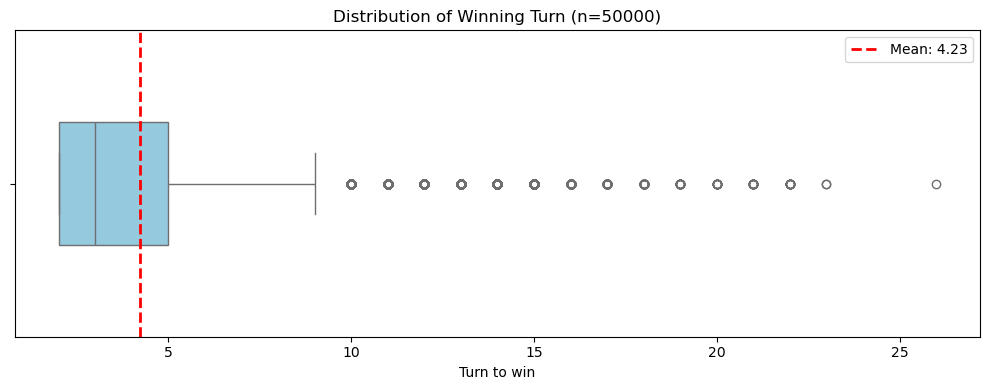

Wins on turn 2: 13347/50000 -> 26.69% of all games
Wins on or before turn 3: 25782/50000 -> 51.56% of all games


In [31]:
deck_list = {
    "Allosaurus Rider" : 4,
    "Atraxa, Grand Unifier" : 1,
    "Boseiju, Who Endures" : 1,
    "Breeding Pool" : 1,
    "Bridgeworks Battle" : 2,
    "Consign to Memory" : 4,
    "Disciple of Freyalise" : 2,
    "Eldritch Evolution": 4,
    "Endurance": 1,
    "Flooded Strand": 2,
    "Forest": 1,
    "Generous Ent": 2,
    "Ghalta, Stampede Tyrant": 2,
    "Griselbrand": 1,
    "Hedge Maze": 3,
    "Hooting Mandrills": 1, # for now I'll ignore mandrills, I'll implement delve later
    "Island" : 1,
    "Misty Rainforest": 4,
    "Neoform": 4,
    "Pact of Negation" : 4,
    "Planar Genesis": 4,
    "Preordain": 0,
    "Scalding Tarn": 2,
    "Summoner's Pact": 4, # for now we'll just consider pact as additional copies of Rider
    "Veil of Summer": 4,
    "Xenagos, God of Revels": 1
}

deck = initialize_deck(deck_list)
total = len(deck)
green_count = sum(1 for _, tags in deck if getattr(tags, "green", False))
land_count = sum(1 for _, tags in deck if getattr(tags, "land", False))

print(f"Green cards: {green_count}/{total} ({green_count/total*100:.2f}%)")
print(f"Lands: {land_count}/{total} ({land_count/total*100:.2f}%)")

fetch_count = sum(1 for _, tags in deck if getattr(tags, "fetch", False))
pct_fetch_of_lands = fetch_count / land_count * 100

print(f"Fetch lands: {fetch_count}/{land_count} ({pct_fetch_of_lands:.2f}% of lands)")

n_sims = 50000
n_jobs = 1  # set to desired number of parallel workers, -1 uses all cores

# run simulations in parallel
results = Parallel(n_jobs=n_jobs)(
    delayed(simulate_game_on_play_no_mull)(deck_list) for _ in tqdm(range(n_sims))
)

# extract the win turn (or None) from each result
win = [res[0] if res is not None else None for res in results]

win = np.array(win, dtype=float)
average_turn_win = np.mean(win)
median_turn_win = np.median(win)

print(f'This list wins on average on turn : {average_turn_win}, median : {median_turn_win}')

# clean NaNs (games that didn't win)
wins_clean = win[~np.isnan(win)]

plt.figure(figsize=(10, 4))
ax = sns.boxplot(x=wins_clean, color="skyblue", width=0.4)

ax.set_xlabel("Turn to win")
ax.set_title(f"Distribution of Winning Turn (n={len(wins_clean)})")

# annotate mean and median
ax.axvline(average_turn_win, color="red", linestyle="--", linewidth=2, label=f"Mean: {average_turn_win:.2f}")
# ax.axvline(median_turn_win, color="green", linestyle="-.", linewidth=2, label=f"Median: {median_turn_win:.0f}")

ax.legend()
plt.tight_layout()
plt.show()

count_turn2 = int(np.sum(win == 2))
pct_of_all = count_turn2 / win.size * 100
pct_of_wins = count_turn2 / wins_clean.size * 100 if wins_clean.size > 0 else np.nan

print(f"Wins on turn 2: {count_turn2}/{win.size} -> {pct_of_all:.2f}% of all games")

count_turn3 = int(np.sum(win <= 3))
pct_of_all_3 = count_turn3 / win.size * 100
pct_of_wins_3 = count_turn3 / wins_clean.size * 100 if wins_clean.size > 0 else np.nan

print(f"Wins on or before turn 3: {count_turn3}/{win.size} -> {pct_of_all_3:.2f}% of all games")

Green cards: 32/60 (53.33%)
Lands: 17/60 (28.33%)
Fetch lands: 8/17 (47.06% of lands)


100%|██████████| 50000/50000 [00:23<00:00, 2158.36it/s]


This list wins on average on turn : 4.33742, median : 3.0


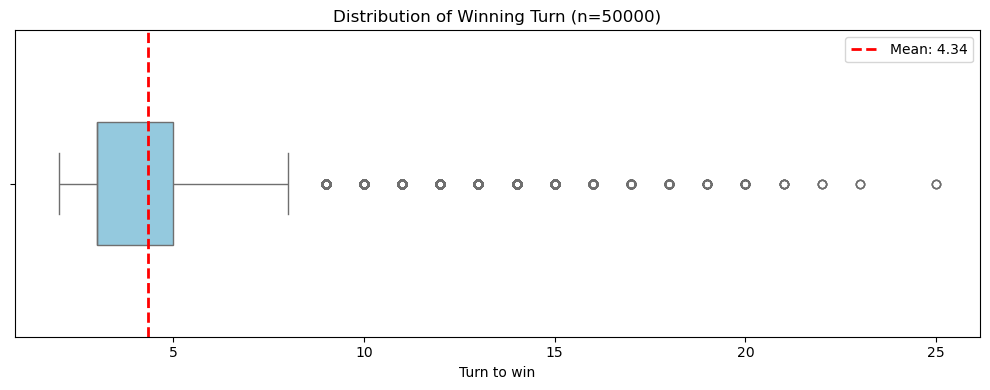

Wins on turn 2: 12248/50000 -> 24.50% of all games
Wins on or before turn 3: 25077/50000 -> 50.15% of all games


In [39]:
deck_list = {
    "Allosaurus Rider" : 4,
    "Atraxa, Grand Unifier" : 1,
    "Boseiju, Who Endures" : 1,
    "Breeding Pool" : 2,
    "Bridgeworks Battle" : 0,
    "Consign to Memory" : 4,
    "Disciple of Freyalise" : 2,
    "Eldritch Evolution": 4,
    "Endurance": 1,
    "Flooded Strand": 2,
    "Forest": 1,
    "Generous Ent": 2,
    "Ghalta, Stampede Tyrant": 2,
    "Griselbrand": 1,
    "Hedge Maze": 2,
    "Hooting Mandrills": 1, # for now I'll ignore mandrills, I'll implement delve later
    "Island" : 1,
    "Misty Rainforest": 4,
    "Neoform": 4,
    "Pact of Negation" : 4,
    "Planar Genesis": 2,
    "Preordain": 4,
    "Scalding Tarn": 2,
    "Summoner's Pact": 4, # for now we'll just consider pact as additional copies of Rider
    "Veil of Summer": 4,
    "Xenagos, God of Revels": 1
}


deck = initialize_deck(deck_list)
total = len(deck)
green_count = sum(1 for _, tags in deck if getattr(tags, "green", False))
land_count = sum(1 for _, tags in deck if getattr(tags, "land", False))

print(f"Green cards: {green_count}/{total} ({green_count/total*100:.2f}%)")
print(f"Lands: {land_count}/{total} ({land_count/total*100:.2f}%)")

fetch_count = sum(1 for _, tags in deck if getattr(tags, "fetch", False))
pct_fetch_of_lands = fetch_count / land_count * 100

print(f"Fetch lands: {fetch_count}/{land_count} ({pct_fetch_of_lands:.2f}% of lands)")

n_sims = 50000
n_jobs = 1  # set to desired number of parallel workers, -1 uses all cores

# run simulations in parallel
results = Parallel(n_jobs=n_jobs)(
    delayed(simulate_game_on_play_no_mull)(deck_list) for _ in tqdm(range(n_sims))
)

# extract the win turn (or None) from each result
win = [res[0] if res is not None else None for res in results]

win = np.array(win, dtype=float)
average_turn_win = np.mean(win)
median_turn_win = np.median(win)

print(f'This list wins on average on turn : {average_turn_win}, median : {median_turn_win}')

# clean NaNs (games that didn't win)
wins_clean = win[~np.isnan(win)]

plt.figure(figsize=(10, 4))
ax = sns.boxplot(x=wins_clean, color="skyblue", width=0.4)

ax.set_xlabel("Turn to win")
ax.set_title(f"Distribution of Winning Turn (n={len(wins_clean)})")

# annotate mean and median
ax.axvline(average_turn_win, color="red", linestyle="--", linewidth=2, label=f"Mean: {average_turn_win:.2f}")
# ax.axvline(median_turn_win, color="green", linestyle="-.", linewidth=2, label=f"Median: {median_turn_win:.0f}")

ax.legend()
plt.tight_layout()
plt.show()

count_turn2 = int(np.sum(win == 2))
pct_of_all = count_turn2 / win.size * 100
pct_of_wins = count_turn2 / wins_clean.size * 100 if wins_clean.size > 0 else np.nan

print(f"Wins on turn 2: {count_turn2}/{win.size} -> {pct_of_all:.2f}% of all games")

count_turn3 = int(np.sum(win <= 3))
pct_of_all_3 = count_turn3 / win.size * 100
pct_of_wins_3 = count_turn3 / wins_clean.size * 100 if wins_clean.size > 0 else np.nan

print(f"Wins on or before turn 3: {count_turn3}/{win.size} -> {pct_of_all_3:.2f}% of all games")